# EEG Feature Extraction 1: Frequency and Time Domain Features
In 2008, a BCI Competition was held on EEG datasets to find the best ML and statistical algorithms to differentiate different classes of neural data. The BCI Competition IV 2b is a motor imagery dataset with eye artifact data, making it a very realistic dataset. The subjects are prompted to imagine left vs right hand movement and the EEG + EOG signals for each trial are collected. We here have provided a simpler version of the dataset in CSV format for you to get started with. 

This notebook will help you get a better understanding of the techniques used to preprocess and extract features from EEG data. These features can then be used to help inform machine learning models how to classify different categories of data. 

Terminology: <br> 
- <b>Feature Extraction</b>: Ways of representing cleaned data in a succinct way for models to learn. 
- More terms defined in each feature extraction section

Feature Extraction Slides: https://docs.google.com/presentation/d/1bfYNgjLitg9CQeB07PRVENiHHGQlex1gP6aEo3pi0rM/edit#slide=id.ga3c369701a_2_20 <br>
Competition link: http://www.bbci.de/competition/iv/desc_2b.pdf <br>
Experiment Setup: http://www.bbci.de/competition/iv/desc_2b.pdf <br>
General Overview of Feature Extraction for Motor Imagery: https://ieeexplore.ieee.org/abstract/document/8250265 <br>
PyEEG: http://pyeeg.sourceforge.net/ <br>



## Imports

In [1]:
from pathlib import Path # For making paths compatible on Windows and Macs
!pip install git+https://github.com/forrestbao/pyeeg.git
import pandas as pd # For working with DataFrames 
import pickle
from pylab import rcParams
import numpy as np # For ease of array manipulation, stats, and some feature extraction
import matplotlib.pyplot as plt # For plotting pretty plots :) 
import scipy.signal as signal # For calculating PSDs and plotting spectrograms
from sklearn.feature_selection import mutual_info_classif
import pyeeg # For pyeeg implemented features
from statistics import variance
from sklearn import preprocessing
default_figsize = [6.4, 4.8]
rcParams["figure.figsize"] = default_figsize

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-uli3xyyt
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-uli3xyyt
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28132 sha256=7839b12eaf99e0eae17272bedce7ea4d8aa29d54b9887add00972b966062a175
  Stored in directory: /tmp/pip-ephem-wheel-cache-_i8ljngg/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


## Load Data
Loading compeititon data from Kaggles, custom feature extraction files from Github

*   [Mount Google Drive](https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa) </br>
*   [Structure Colab Project](https://neptune.ai/blog/google-colab-dealing-with-files)
*   [Git LFS](https://stackoverflow.com/questions/54451856/how-can-i-tell-if-a-file-will-begrrectly)
*   [Git Detached Head State](https://www.cloudbees.com/blog/git-detached-head)
*   [Download data from Kaggles on Colab](https://www.kaggle.com/c/ucsd-neural-data-challenge/data)



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# path need not to be modified if this folder is in the root directory of the drive
%cd '/content/gdrive/MyDrive/Neural Data Competition'

/content/gdrive/MyDrive/Neural Data Competition


## Constants

In [4]:
eeg_fs = 250 # Data was recorded at 250 Hz
eeg_chans = ["C3", "Cz", "C4"] # 10-20 system 
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"] 
all_chans = eeg_chans + eog_chans
event_types = {0:"left", 1:"right"}

## Helper Functions

In [5]:
# Multiple bar graph plotting
def plotMultipleBarGraphs(bars, bar_width, bar_names, group_names, error_values=None, title=None, xlabel=None, ylabel=None, figsize=default_figsize):
    if len(bar_names) != len(bars):
        print("group names must be same length as bars")
        return 
    # Set position of bar on X axis
    positions = list()
    positions.append(np.arange(len(bars[0])))
    for i, bar in enumerate(bars): 
        if i>0: 
            positions.append([x + bar_width for x in positions[i-1]])


    # Make the plot
    for i, pos in enumerate(positions):
        plt.bar(pos, bars[i], width=bar_width, label=bar_names[i])
    
    if error_values is not None: 
        for i, pos in enumerate(positions):
            plt.errorbar(pos, bars[i], yerr=error_values[i], fmt='.k')
    
    # Add xticks on the middle of the group bars
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)
    plt.xticks([r + bar_width for r in range(len(bars[0]))], group_names)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

    

## Load Epoched Data

In [6]:
# These + epoched_test.pkl are the epochs that will be used in accuracy evaluation
epoch_df_filename = Path("./data/epoched_train.pkl")
eeg_epoch_full_df = pd.read_pickle(epoch_df_filename)
train_df = eeg_epoch_full_df.drop(["patient_id", "start_time", "event_type"], axis=1)
eeg_epoch_full_df.head(2)

,patient_id,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,B0101T,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,B0101T,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."


## PyEEG Features

In [7]:
# Power Bin extraction
import pyeeg
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power_ratio)
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

### >> Power Bin
Power Bins are very widely used for EEG analysis to reduce PSDs into fewer features for Machine Learning. Spectral Power in the bin normalized by power in all spectral bins. 

In [8]:
# Create a dataframe with the event_type and the power bin information for each trial

power_ratios = {'y': []}
binning=[0.5, 4, 7, 12, 30]
intervals = getIntervals(binning)
for i in range(0, len(eeg_epoch_full_df)): 
    event_type = eeg_epoch_full_df['event_type'][i]
    for ch in eeg_chans: 
        ratios = getPowerRatio(eeg_epoch_full_df[ch][i][:], binning)
        for j, interval in enumerate(intervals): 
            key = ch + "_" + str(interval)
            if key not in power_ratios: 
                power_ratios[key] = list()
            power_ratios[key].append(ratios[j])
    power_ratios['y'].append(eeg_epoch_full_df['event_type'][i])

power_ratios_df = pd.DataFrame(power_ratios)
power_ratios_df

,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)"
0,0,0.190380,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032
1,1,0.338060,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698
2,0,0.234302,0.101459,0.162443,0.501796,0.191182,0.157964,0.189180,0.461674,0.235221,0.127780,0.156822,0.480177
3,1,0.247263,0.139796,0.177430,0.435511,0.316947,0.093709,0.204395,0.384950,0.289331,0.099774,0.166477,0.444418
4,1,0.249109,0.107688,0.202389,0.440814,0.189605,0.109879,0.284962,0.415554,0.249175,0.093967,0.197290,0.459568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0,0.195891,0.075325,0.257330,0.471455,0.211117,0.102889,0.276662,0.409331,0.203611,0.095978,0.217851,0.482560
3676,1,0.209756,0.119400,0.187416,0.483428,0.218968,0.133610,0.208398,0.439024,0.157315,0.128064,0.215788,0.498833
3677,1,0.258251,0.103080,0.167714,0.470955,0.262359,0.126358,0.194668,0.416615,0.254516,0.100865,0.170526,0.474093
3678,0,0.161371,0.116040,0.233203,0.489387,0.207181,0.131806,0.299261,0.361751,0.162001,0.109415,0.281360,0.447223


In [9]:
# Calculate the standard error means between epochs for each channel from the power ratios obtained previously

chan_frequency_sems = {}
chan_frequency_avgs = {}

for event_type in event_types: 
    for ch in eeg_chans: 
        for interval in intervals: 
            key = ch + "_" + str(interval)
            if key not in chan_frequency_sems: 
                chan_frequency_sems[key] = list()
                chan_frequency_avgs[key] = list()
            this_data = power_ratios_df[power_ratios_df['y'] == event_type][key]
            sem = np.std(this_data) / np.sqrt(len(this_data)) # Standard Error of Mean calculation
            chan_frequency_sems[key].append(sem)
            chan_frequency_avgs[key].append(np.mean(this_data))
            
std_err_df = pd.DataFrame(chan_frequency_sems)
avg_df = pd.DataFrame(chan_frequency_avgs)

,0,1
0,0.239021,0.253277
1,0.119270,0.121703
2,0.227392,0.218150
3,0.414316,0.406869


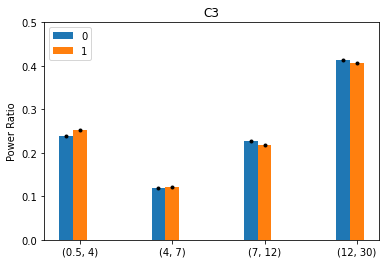

array([[0.23902142, 0.11927045, 0.22739165, 0.41431649],
       [0.25327725, 0.12170339, 0.2181499 , 0.40686946]])

,0,1
0,0.258218,0.258372
1,0.137345,0.135454
2,0.236456,0.237395
3,0.367981,0.368779


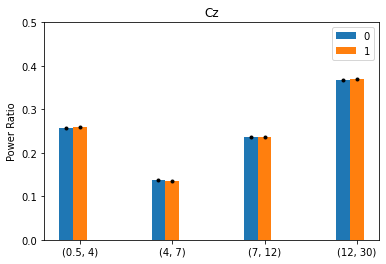

array([[0.25821764, 0.13734545, 0.23645628, 0.36798064],
       [0.2583722 , 0.13545366, 0.23739526, 0.36877888]])

,0,1
0,0.242126,0.225854
1,0.121801,0.116100
2,0.218932,0.233285
3,0.417140,0.424762


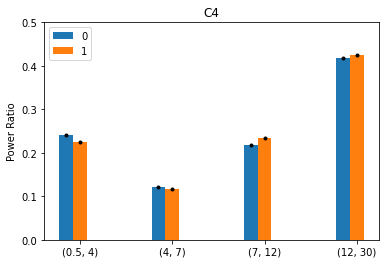

array([[0.24212625, 0.12180121, 0.21893238, 0.41714016],
       [0.22585369, 0.11609952, 0.23328462, 0.42476217]])

In [10]:
# Plot average power ratios for each electrode

for chan in eeg_chans: 
    chan_of_interest = chan
    event_power_ratios = {}
    event_sems = {}
    power_ratios_for_chan = []
    sem_for_chan = []
    for event_type in event_types: 
        if event_type not in event_power_ratios: 
            event_power_ratios[event_type] = []
            event_sems[event_type] = []
        for interval in intervals: 
            key = chan_of_interest + "_" + str(interval)
            event_power_ratios[event_type].append(avg_df[key][event_type])
            event_sems[event_type].append(std_err_df[key][event_type])

    event_sems_df = pd.DataFrame(event_sems)
    event_power_ratios_df = pd.DataFrame(event_power_ratios)
    display(event_power_ratios_df)
    plt.title(chan_of_interest)
    plt.ylim((0, 0.5))
    plt.ylabel("Power Ratio")
    plotMultipleBarGraphs(np.transpose(np.array(event_power_ratios_df)), 0.15, [0, 1], intervals, error_values=np.transpose(np.array(event_sems_df)))
    display(np.transpose(np.array(event_power_ratios_df)))
    

### >> Power Band Ratios
Band ratios can be helpful because they help characterize the ratio between different power bins within a trial. Here we provide getting theta / beta ratios, but you can try other combinations! 

In [11]:
## Get band ratio features 

theta_beta_ratios = {} # Keys will be chan_theta_beta
# Iterate through rows of power_ratios_df
for i, row in power_ratios_df.iterrows(): 
    for ch in eeg_chans: 
        curr_key = ch + "_theta_beta"
        if curr_key not in theta_beta_ratios: 
            theta_beta_ratios[curr_key] = []
            
        # Calculate band ratios and append to dictionary
        power_bin_theta_key = ch + "_(4, 7)"
        power_bin_beta_key = ch + "_(12, 30)"
        theta_val = row[power_bin_theta_key]
        beta_val = row[power_bin_beta_key]
        theta_beta_ratios[curr_key].append(theta_val / beta_val)

# Create df for band ratios: band_ratios_df 
band_ratios_df = pd.DataFrame(theta_beta_ratios)
display(band_ratios_df.head(2))

# Concatenate power_ratios_df with band_ratios_df to get full feature df
feature_df = pd.concat([power_ratios_df, band_ratios_df], axis=1)
display(feature_df.head(2))

,C3_theta_beta,Cz_theta_beta,C4_theta_beta
0,0.222452,0.24095,0.192458
1,0.175444,0.25083,0.333788


,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)",C3_theta_beta,Cz_theta_beta,C4_theta_beta
0,0,0.19038,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032,0.222452,0.24095,0.192458
1,1,0.33806,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698,0.175444,0.25083,0.333788


### Channel Relationships
Channel differences and ratios can provide spatial insights! 

In [12]:
## Get channel ratio features

# Similar algorithm as Band Ratios, but for each interval
C3_C4_differences = {} 
for i, row in power_ratios_df.iterrows(): 
    for interval in intervals: 
        curr_key = "C3_C4_diff_" + str(interval)
        if curr_key not in C3_C4_differences: 
            C3_C4_differences[curr_key] = []
            
        # Calculate band ratios and append to dictionary
        power_bin_C3_key = "C3_" + str(interval)
        power_bin_C4_key = "C4_" + str(interval)
        
        C3_val = row[power_bin_C3_key]
        C4_val = row[power_bin_C4_key]
        
        C3_C4_differences[curr_key].append(C3_val - C4_val)

# Create df for band ratios: band_ratios_df 
C3_C4_differences_df = pd.DataFrame(C3_C4_differences)
display(C3_C4_differences_df.head(2))

# Concatenate power_ratios_df with band_ratios_df to get full feature df
feature_df = pd.concat([power_ratios_df, band_ratios_df, C3_C4_differences_df], axis=1)
feature_df

,"C3_C4_diff_(0.5, 4)","C3_C4_diff_(4, 7)","C3_C4_diff_(7, 12)","C3_C4_diff_(12, 30)"
0,0.013933,0.005190,0.026448,-0.045572
1,-0.131600,-0.021204,-0.003139,0.155944


,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)",C3_theta_beta,Cz_theta_beta,C4_theta_beta,"C3_C4_diff_(0.5, 4)","C3_C4_diff_(4, 7)","C3_C4_diff_(7, 12)","C3_C4_diff_(12, 30)"
0,0,0.190380,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032,0.222452,0.240950,0.192458,0.013933,0.005190,0.026448,-0.045572
1,1,0.338060,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698,0.175444,0.250830,0.333788,-0.131600,-0.021204,-0.003139,0.155944
2,0,0.234302,0.101459,0.162443,0.501796,0.191182,0.157964,0.189180,0.461674,0.235221,0.127780,0.156822,0.480177,0.202192,0.342156,0.266110,-0.000919,-0.026321,0.005621,0.021619
3,1,0.247263,0.139796,0.177430,0.435511,0.316947,0.093709,0.204395,0.384950,0.289331,0.099774,0.166477,0.444418,0.320994,0.243432,0.224504,-0.042068,0.040023,0.010953,-0.008907
4,1,0.249109,0.107688,0.202389,0.440814,0.189605,0.109879,0.284962,0.415554,0.249175,0.093967,0.197290,0.459568,0.244292,0.264417,0.204467,-0.000065,0.013721,0.005098,-0.018754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0,0.195891,0.075325,0.257330,0.471455,0.211117,0.102889,0.276662,0.409331,0.203611,0.095978,0.217851,0.482560,0.159770,0.251360,0.198893,-0.007720,-0.020653,0.039479,-0.011106
3676,1,0.209756,0.119400,0.187416,0.483428,0.218968,0.133610,0.208398,0.439024,0.157315,0.128064,0.215788,0.498833,0.246987,0.304334,0.256727,0.052440,-0.008663,-0.028372,-0.015405
3677,1,0.258251,0.103080,0.167714,0.470955,0.262359,0.126358,0.194668,0.416615,0.254516,0.100865,0.170526,0.474093,0.218876,0.303297,0.212753,0.003735,0.002216,-0.002812,-0.003139
3678,0,0.161371,0.116040,0.233203,0.489387,0.207181,0.131806,0.299261,0.361751,0.162001,0.109415,0.281360,0.447223,0.237113,0.364357,0.244655,-0.000631,0.006625,-0.048158,0.042164


### >> First and Second Difference of Power Ratio across Trials
Helpful for seeing how dramatically changing the recorded values 

In [13]:
## Get first and second order diffs
# pyeeg.first_order_diff(X) for first order diffs (does not work rip)
C3_first_order_differences = {}
for interval in intervals: 
    preval = power_ratios_df["C3_" + str(interval)][0]
    for i, row in power_ratios_df.drop(0).iterrows(): 
        curr_key = "C3_first_order_differences_" + str(interval)
        if curr_key not in C3_first_order_differences: 
            C3_first_order_differences[curr_key] = []
        proval = row["C3_" + str(interval)]
        C3_first_order_differences[curr_key].append(proval - preval)
        preval = row["C3_" + str(interval)]
C3_first_order_differences_df = pd.DataFrame(C3_first_order_differences)
display(C3_first_order_differences_df.head())
# Write your own second order diff algorithm! 
C3_second_order_differences = {}
for interval in intervals: 
    j = 2
    proval = power_ratios_df["C3_" + str(interval)][j]
    for i, row in power_ratios_df.drop([len(power_ratios_df) - 2, len(power_ratios_df) - 1]).iterrows(): 
        curr_key = "C3_second_order_differences_" + str(interval)
        if curr_key not in C3_second_order_differences: 
            C3_second_order_differences[curr_key] = []
        preval = row["C3_" + str(interval)]
        C3_second_order_differences[curr_key].append(proval - preval)
        proval = power_ratios_df["C3_" + str(interval)][j + 1]
C3_second_order_differences_df = pd.DataFrame(C3_second_order_differences)
display(C3_second_order_differences_df.head())

,"C3_first_order_differences_(0.5, 4)","C3_first_order_differences_(4, 7)","C3_first_order_differences_(7, 12)","C3_first_order_differences_(12, 30)"
0,0.147680,-0.022375,-0.122487,-0.002818
1,-0.103758,0.020291,0.044313,0.039154
2,0.012960,0.038337,0.014987,-0.066285
3,0.001847,-0.032109,0.024959,0.005303
4,0.048331,-0.014208,0.014884,-0.049008


,"C3_second_order_differences_(0.5, 4)","C3_second_order_differences_(4, 7)","C3_second_order_differences_(7, 12)","C3_second_order_differences_(12, 30)"
0,0.043922,-0.002084,-0.078174,0.036336
1,-0.090798,0.058628,0.059300,-0.027131
2,0.012960,0.038337,0.014987,-0.066285
3,0.000000,0.000000,0.000000,0.000000
4,-0.001847,0.032109,-0.024959,-0.005303
